# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
# 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [281]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from nltk.corpus import stopwords

import time
import pickle

pd.set_option('display.max_colwidth', -1)
%matplotlib inline
nltk.download('wordnet')
nltk.download('stopwords')
pd.options.display.max_colwidth = 100

[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# load data from database
engine = create_engine('sqlite:///disasters.db')
df = pd.read_sql_table("messages", con=engine)
df.head(2)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that could pass over Haiti,Un front froid se retrouve sur Cuba ce matin. Il pourrait traverser Haiti demain. Des averses de...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0


In [191]:
x = df[["message", "genre"]]
y = df.drop(axis=1, labels=["id", "message", "original", "genre"])
x.columns, y.columns

(Index(['message', 'genre'], dtype='object'),
 Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
        'medical_products', 'search_and_rescue', 'security', 'military',
        'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
        'missing_people', 'refugees', 'death', 'other_aid',
        'infrastructure_related', 'transport', 'buildings', 'electricity',
        'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
        'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
        'other_weather', 'direct_report'],
       dtype='object'))

# 2. Write a tokenization function to process your text data

In [192]:
def tokenize(text):
    
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    tokens = word_tokenize(text)
    
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    
    for token in tokens:
        clean_tok = lemmatizer.lemmatize(token).lower().strip()
        
        # remove stop words 
        if clean_tok not in set(stopwords.words("english")):
            clean_tokens.append(clean_tok)
        
    return clean_tokens

### Give up the classification of "child alone"

Since the dataset given has no "child_alone" message, the model made from this cannot classify "child_alone" label (the model cannot made). Thus, I remove the label "childhood_alone" from the dataset

In [196]:
one_counts = pd.Series(index=y.columns)
for col in y:
    one_counts[col] = y[col].sum().astype("int64")
    
print(one_counts.sort_values()[:5])
print(one_counts.sort_values()[-5:])

child_alone      0.0
offer          118.0
shops          120.0
tools          159.0
fire           282.0
dtype: float64
request             4474.0
direct_report       5075.0
weather_related     7297.0
aid_related        10860.0
related            19906.0
dtype: float64


In [171]:
y = y.drop(axis=1, labels="child_alone")

In [180]:
x_train, x_test, y_train, y_test = train_test_split(x.message, y, random_state=42)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip..._score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=None))])

In [179]:
def plot_scores(y, y_pred):
    
    f1_series = pd.Series()
    
    for i_col in range(y.shape[1]):
        print(y.columns[i_col])
        print(classification_report(y.iloc[:,i_col], y_pred[:,i_col]))
        f1_series[y.columns[i_col]] = f1_score(y.iloc[:,i_col], y_pred[:,i_col])
    plt.figure(figsize=[12,6])
    f1_series.sort_values(ascending=False).plot("bar", colormap="Blues_r")
    print("f1 score mean : ", f1_series.mean())

# 3.Try some models

Before using the Grid Search, I try some models with default parameters to roughly grab which model is suitable for this case.
I will try these 3 classification models. In this case, I would focus on f1-score. (Inside of parentheses are mean f1 scores of labels. It does not make sense because the number of messages in each label varies. However I used this just to compare the characteristics of the models) 

* Random Forest Classifier (training 0.914, test  0.252)
* Naive Bayes Classifier (training 0.110, test 0.084)
* Logistic Regression Classifier (training 0.909, testing 0.242)
* Classification by vec2 words 0.242567608157178



## ***Test1 Random Forest Classifier***

### Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [209]:
pipeline1 = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", MultiOutputClassifier(RandomForestClassifier()))])

### Train pipeline
- Split data into train and test sets
- Train pipeline

In [210]:
#train the model
pipeline1.fit(x_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip..._score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=None))])

related
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4700
           1       0.99      0.99      0.99     14962

   micro avg       0.99      0.99      0.99     19662
   macro avg       0.99      0.98      0.99     19662
weighted avg       0.99      0.99      0.99     19662

request
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     16299
           1       1.00      0.93      0.96      3363

   micro avg       0.99      0.99      0.99     19662
   macro avg       0.99      0.96      0.98     19662
weighted avg       0.99      0.99      0.99     19662

offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19577
           1       1.00      0.72      0.84        85

   micro avg       1.00      1.00      1.00     19662
   macro avg       1.00      0.86      0.92     19662
weighted avg       1.00      1.00      1.00     1966

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18026
           1       1.00      0.91      0.95      1636

   micro avg       0.99      0.99      0.99     19662
   macro avg       1.00      0.95      0.97     19662
weighted avg       0.99      0.99      0.99     19662

storm
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     17824
           1       1.00      0.94      0.97      1838

   micro avg       0.99      0.99      0.99     19662
   macro avg       1.00      0.97      0.98     19662
weighted avg       0.99      0.99      0.99     19662

fire
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19446
           1       1.00      0.82      0.90       216

   micro avg       1.00      1.00      1.00     19662
   macro avg       1.00      0.91      0.95     19662
weighted avg       1.00      1.00      1.00     19662

earthqua

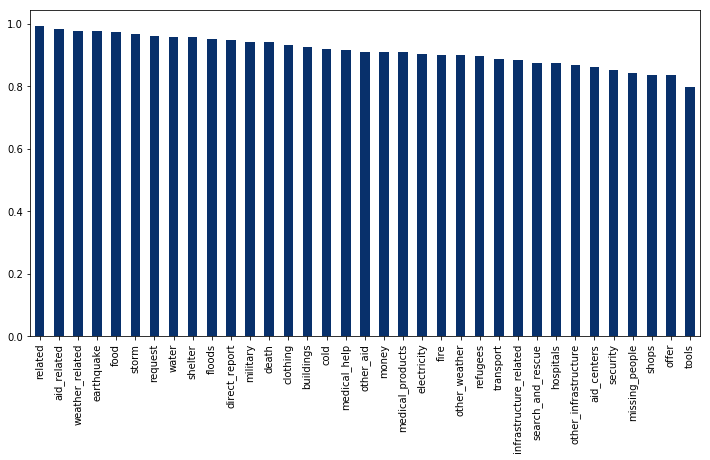

In [211]:
# scores of train data
y_train_pred = pipeline1.predict(x_train)
plot_scores(y_train, y_train_pred)

### Test the model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

related
              precision    recall  f1-score   support

           0       0.60      0.45      0.52      1610
           1       0.83      0.90      0.87      4944

   micro avg       0.79      0.79      0.79      6554
   macro avg       0.72      0.68      0.69      6554
weighted avg       0.78      0.79      0.78      6554

request
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      5443
           1       0.76      0.42      0.54      1111

   micro avg       0.88      0.88      0.88      6554
   macro avg       0.83      0.70      0.74      6554
weighted avg       0.87      0.88      0.86      6554

offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6521
           1       0.00      0.00      0.00        33

   micro avg       0.99      0.99      0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.99      0.99      0.99      655

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5973
           1       0.80      0.34      0.48       581

   micro avg       0.93      0.93      0.93      6554
   macro avg       0.87      0.67      0.72      6554
weighted avg       0.93      0.93      0.92      6554

clothing
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6456
           1       0.86      0.06      0.11        98

   micro avg       0.99      0.99      0.99      6554
   macro avg       0.92      0.53      0.55      6554
weighted avg       0.98      0.99      0.98      6554

money
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6421
           1       0.77      0.08      0.14       133

   micro avg       0.98      0.98      0.98      6554
   macro avg       0.88      0.54      0.56      6554
weighted avg       0.98      0.98      0.97      6554

miss

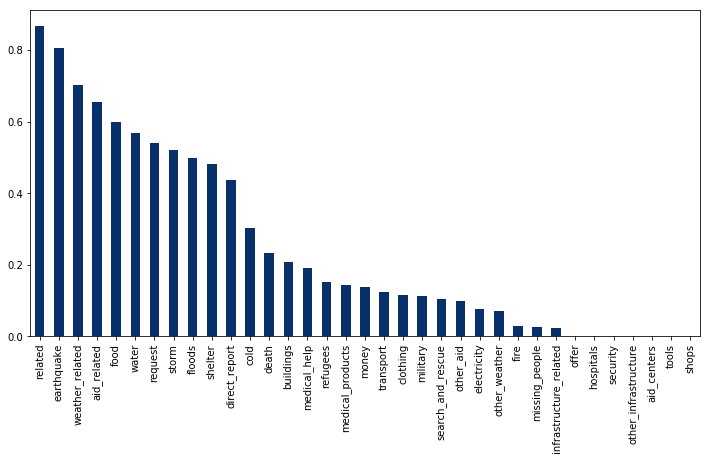

In [188]:
# scores of test data
y_test_pred = pipeline.predict(x_test)
plot_scores(y_test, y_test_pred)

#### The result suggests that the classification accuracy varies depending on the labels. It seems like the labels to which less messages in the dataset was classified worse. 

## ***Test2. Naive Bayes Classifier***

In [201]:
pipeline2 = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", MultiOutputClassifier(MultinomialNB()))])

In [202]:
#train the model
pipeline2.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...fier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
           n_jobs=None))])

related
              precision    recall  f1-score   support

           0       0.93      0.21      0.34      4700
           1       0.80      0.99      0.89     14962

   micro avg       0.81      0.81      0.81     19662
   macro avg       0.86      0.60      0.61     19662
weighted avg       0.83      0.81      0.76     19662

request
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     16299
           1       0.91      0.30      0.45      3363

   micro avg       0.88      0.88      0.88     19662
   macro avg       0.89      0.65      0.69     19662
weighted avg       0.88      0.88      0.85     19662

offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19577
           1       0.00      0.00      0.00        85

   micro avg       1.00      1.00      1.00     19662
   macro avg       0.50      0.50      0.50     19662
weighted avg       0.99      1.00      0.99     1966

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.97      1.00      0.99     19097
           1       0.00      0.00      0.00       565

   micro avg       0.97      0.97      0.97     19662
   macro avg       0.49      0.50      0.49     19662
weighted avg       0.94      0.97      0.96     19662

security
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19307
           1       0.00      0.00      0.00       355

   micro avg       0.98      0.98      0.98     19662
   macro avg       0.49      0.50      0.50     19662
weighted avg       0.96      0.98      0.97     19662

military
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     19002
           1       0.40      0.00      0.01       660

   micro avg       0.97      0.97      0.97     19662
   macro avg       0.68      0.50      0.49     19662
weighted avg       0.95      0.97      0.95     19662

w

f1 score mean :  0.11009798822642657


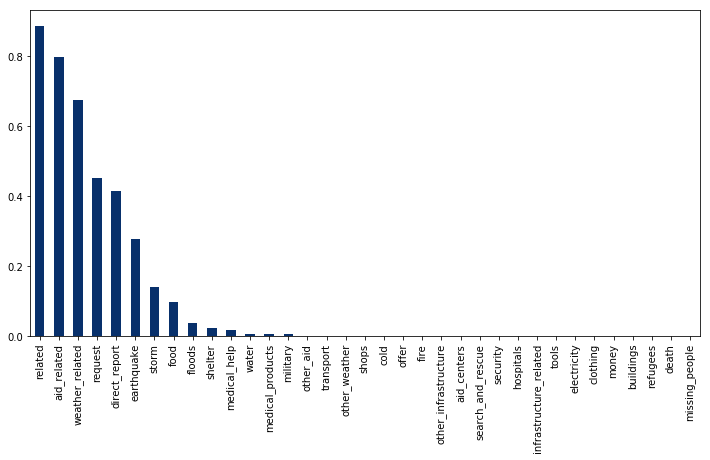

In [203]:
# scores of train data
y_train_pred = pipeline2.predict(x_train)
plot_scores(y_train, y_train_pred)

related
              precision    recall  f1-score   support

           0       0.77      0.09      0.16      1610
           1       0.77      0.99      0.87      4944

   micro avg       0.77      0.77      0.77      6554
   macro avg       0.77      0.54      0.51      6554
weighted avg       0.77      0.77      0.69      6554

request
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      5443
           1       0.84      0.22      0.34      1111

   micro avg       0.86      0.86      0.86      6554
   macro avg       0.85      0.60      0.63      6554
weighted avg       0.86      0.86      0.82      6554

offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6521
           1       0.00      0.00      0.00        33

   micro avg       0.99      0.99      0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.99      0.99      0.99      655

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.87      1.00      0.93      5690
           1       0.00      0.00      0.00       864

   micro avg       0.87      0.87      0.87      6554
   macro avg       0.43      0.50      0.46      6554
weighted avg       0.75      0.87      0.81      6554

infrastructure_related
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      6143
           1       0.00      0.00      0.00       411

   micro avg       0.94      0.94      0.94      6554
   macro avg       0.47      0.50      0.48      6554
weighted avg       0.88      0.94      0.91      6554

transport
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      6251
           1       0.00      0.00      0.00       303

   micro avg       0.95      0.95      0.95      6554
   macro avg       0.48      0.50      0.49      6554
weighted avg       0.91      0.95      0.

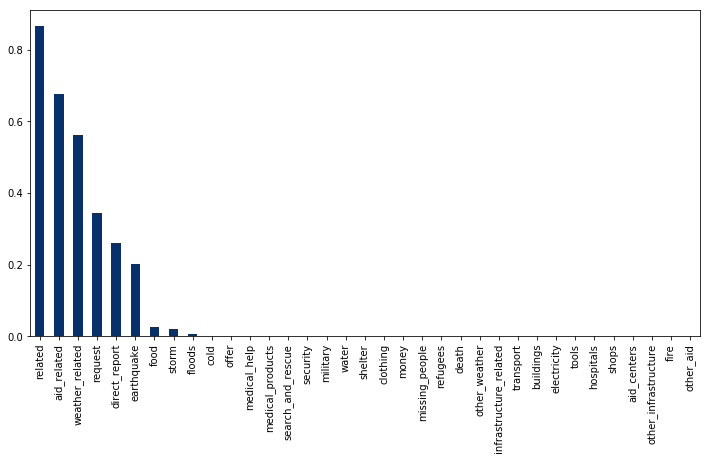

In [204]:
# scores of test data
y_test_pred = pipeline2.predict(x_test)
plot_scores(y_test, y_test_pred)

## ***Test3. Logistic Regression Classifier***

In [259]:
pipeline3 = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", MultiOutputClassifier(LogisticRegression()))])

In [262]:
#train the model

time3 = time.time()

pipeline3.fit(x_train, y_train)

time.time() - time3

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


625.0021512508392

related
              precision    recall  f1-score   support

           0       0.86      0.56      0.68      4700
           1       0.87      0.97      0.92     14962

   micro avg       0.87      0.87      0.87     19662
   macro avg       0.87      0.76      0.80     19662
weighted avg       0.87      0.87      0.86     19662

request
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     16299
           1       0.87      0.56      0.68      3363

   micro avg       0.91      0.91      0.91     19662
   macro avg       0.89      0.77      0.82     19662
weighted avg       0.91      0.91      0.90     19662

offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19577
           1       0.00      0.00      0.00        85

   micro avg       1.00      1.00      1.00     19662
   macro avg       0.50      0.50      0.50     19662
weighted avg       0.99      1.00      0.99     1966

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     18113
           1       0.82      0.20      0.32      1549

   micro avg       0.93      0.93      0.93     19662
   macro avg       0.88      0.60      0.64     19662
weighted avg       0.93      0.93      0.91     19662

medical_products
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18693
           1       0.89      0.20      0.33       969

   micro avg       0.96      0.96      0.96     19662
   macro avg       0.92      0.60      0.65     19662
weighted avg       0.96      0.96      0.95     19662

search_and_rescue
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     19097
           1       0.90      0.08      0.14       565

   micro avg       0.97      0.97      0.97     19662
   macro avg       0.94      0.54      0.56     19662
weighted avg       0.97      0.97      

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     17824
           1       0.87      0.50      0.64      1838

   micro avg       0.95      0.95      0.95     19662
   macro avg       0.91      0.75      0.80     19662
weighted avg       0.94      0.95      0.94     19662

fire
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19446
           1       0.93      0.06      0.11       216

   micro avg       0.99      0.99      0.99     19662
   macro avg       0.96      0.53      0.55     19662
weighted avg       0.99      0.99      0.99     19662

earthquake
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17797
           1       0.93      0.70      0.80      1865

   micro avg       0.97      0.97      0.97     19662
   macro avg       0.95      0.85      0.89     19662
weighted avg       0.97      0.97      0.96     19662

col

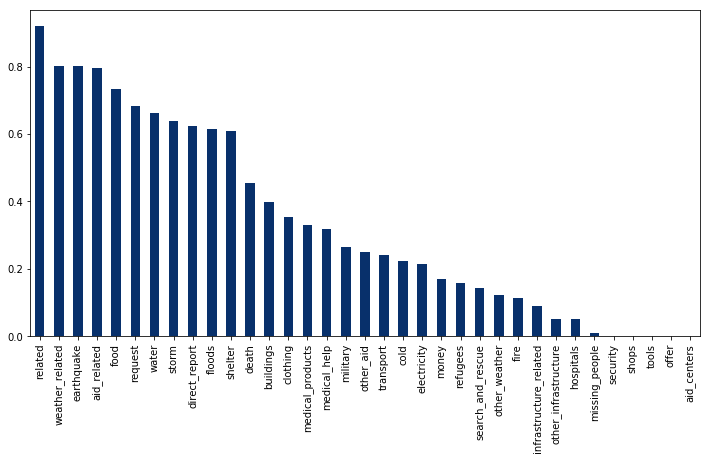

In [263]:
# scores of train data
y_train_pred = pipeline3.predict(x_train)
plot_scores(y_train, y_train_pred)

related
              precision    recall  f1-score   support

           0       0.73      0.41      0.52      1610
           1       0.83      0.95      0.89      4944

   micro avg       0.82      0.82      0.82      6554
   macro avg       0.78      0.68      0.71      6554
weighted avg       0.81      0.82      0.80      6554

request
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      5443
           1       0.83      0.52      0.64      1111

   micro avg       0.90      0.90      0.90      6554
   macro avg       0.87      0.75      0.79      6554
weighted avg       0.90      0.90      0.89      6554

offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6521
           1       0.00      0.00      0.00        33

   micro avg       0.99      0.99      0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.99      0.99      0.99      655

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6136
           1       0.79      0.47      0.59       418

   micro avg       0.96      0.96      0.96      6554
   macro avg       0.88      0.73      0.78      6554
weighted avg       0.95      0.96      0.95      6554

food
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5809
           1       0.86      0.57      0.69       745

   micro avg       0.94      0.94      0.94      6554
   macro avg       0.91      0.78      0.83      6554
weighted avg       0.94      0.94      0.94      6554

shelter
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5973
           1       0.81      0.46      0.59       581

   micro avg       0.94      0.94      0.94      6554
   macro avg       0.88      0.73      0.78      6554
weighted avg       0.94      0.94      0.94      6554

clothi

direct_report
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      5282
           1       0.74      0.41      0.53      1272

   micro avg       0.86      0.86      0.86      6554
   macro avg       0.81      0.69      0.72      6554
weighted avg       0.85      0.86      0.84      6554

f1 score mean :  0.2858801093776617


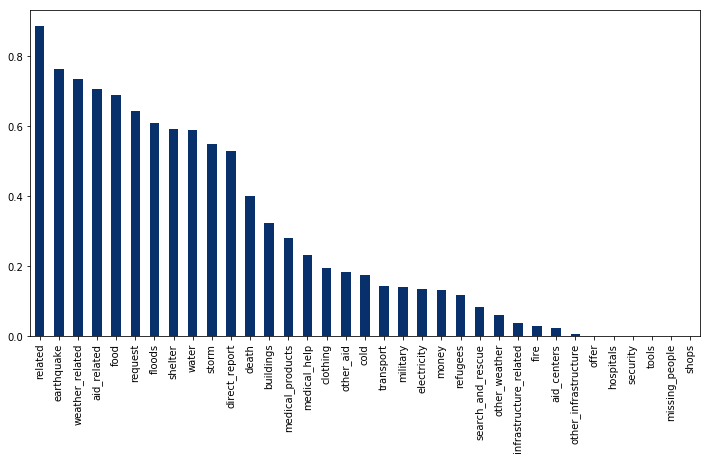

In [264]:
# scores of test data
y_test_pred = pipeline3.predict(x_test)
plot_scores(y_test, y_test_pred)

# Grid Search1 (RandomForest)

In [289]:
pipeline1 = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", MultiOutputClassifier(RandomForestClassifier()))])

In [296]:
parameters1 = {
    "vect__ngram_range" : [(1,1), (1,2)],
    #"vect__max_df" : [0.5,1],
    "vect__max_features" : [None, 5000, 10000],
    #"tfidf__use_idf" : [True, False],
    "clf__estimator__n_estimators" : [50,100,200],
    "clf__estimator__min_samples_split" : [2,3,4]
    }

In [297]:
time_begin = time.time()

cv1 = GridSearchCV(pipeline1, param_grid=parameters1, n_jobs=-1, cv=2)

cv1.fit(x_train, y_train)
print(time.time() - time_begin)

32871.23275184631


related
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4700
           1       1.00      1.00      1.00     14962

   micro avg       1.00      1.00      1.00     19662
   macro avg       1.00      1.00      1.00     19662
weighted avg       1.00      1.00      1.00     19662

request
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     16299
           1       1.00      0.97      0.98      3363

   micro avg       0.99      0.99      0.99     19662
   macro avg       1.00      0.98      0.99     19662
weighted avg       0.99      0.99      0.99     19662

offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19577
           1       1.00      0.48      0.65        85

   micro avg       1.00      1.00      1.00     19662
   macro avg       1.00      0.74      0.82     19662
weighted avg       1.00      1.00      1.00     1966

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19434
           1       1.00      0.61      0.75       228

   micro avg       1.00      1.00      1.00     19662
   macro avg       1.00      0.80      0.88     19662
weighted avg       1.00      1.00      0.99     19662

other_infrastructure
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18794
           1       1.00      0.85      0.92       868

   micro avg       0.99      0.99      0.99     19662
   macro avg       1.00      0.93      0.96     19662
weighted avg       0.99      0.99      0.99     19662

weather_related
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14138
           1       1.00      0.99      0.99      5524

   micro avg       1.00      1.00      1.00     19662
   macro avg       1.00      0.99      1.00     19662
weighted avg       1.00      1.00    

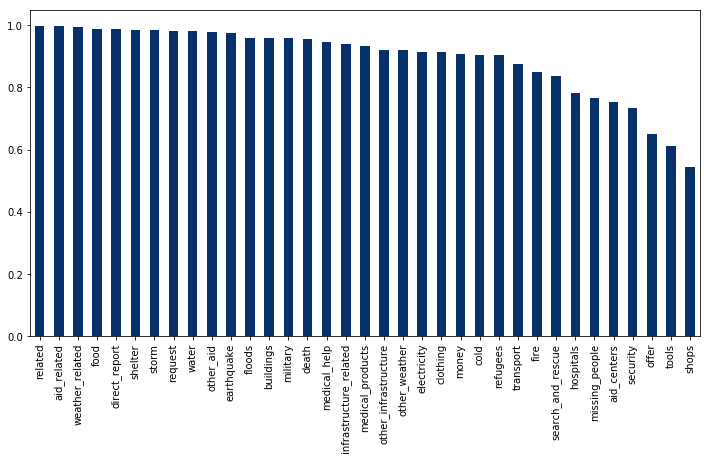

In [298]:
# scores of train data
y_train_pred = cv1.predict(x_train)
plot_scores(y_train, y_train_pred)

related
              precision    recall  f1-score   support

           0       0.67      0.47      0.55      1610
           1       0.84      0.93      0.88      4944

   micro avg       0.81      0.81      0.81      6554
   macro avg       0.76      0.70      0.72      6554
weighted avg       0.80      0.81      0.80      6554

request
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      5443
           1       0.84      0.50      0.63      1111

   micro avg       0.90      0.90      0.90      6554
   macro avg       0.87      0.74      0.79      6554
weighted avg       0.90      0.90      0.89      6554

offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6521
           1       0.00      0.00      0.00        33

   micro avg       0.99      0.99      0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.99      0.99      0.99      655

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


transport
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6251
           1       0.76      0.13      0.22       303

   micro avg       0.96      0.96      0.96      6554
   macro avg       0.86      0.56      0.60      6554
weighted avg       0.95      0.96      0.94      6554

buildings
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6231
           1       0.82      0.17      0.29       323

   micro avg       0.96      0.96      0.96      6554
   macro avg       0.89      0.59      0.63      6554
weighted avg       0.95      0.96      0.94      6554

electricity
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6407
           1       0.94      0.11      0.20       147

   micro avg       0.98      0.98      0.98      6554
   macro avg       0.96      0.55      0.59      6554
weighted avg       0.98      0.98      0.9

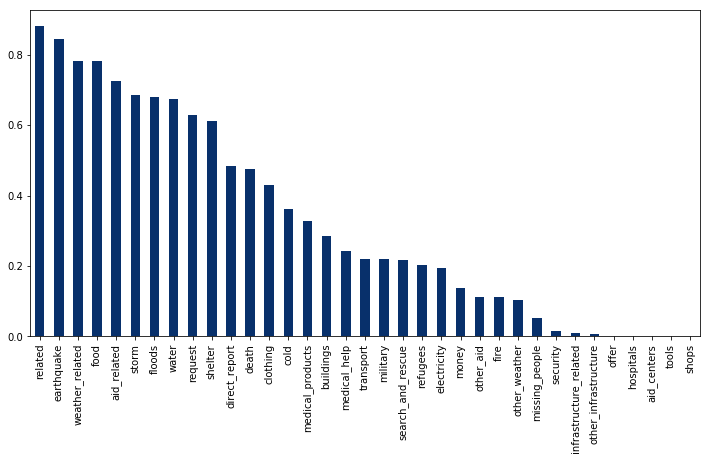

In [299]:
# scores of test data
y_test_pred = cv1.predict(x_test)
plot_scores(y_test, y_test_pred)

# Grid Search2 (LogisticRegression)

In [266]:
pipeline3 = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", MultiOutputClassifier(LogisticRegression()))])

In [287]:
parameters = {
    "vect__ngram_range" : [(1,1), (1,2)],
    #"vect__max_df" : [0.5,1],
    "vect__max_features" : [None, 5000, 10000],
    #"tfidf__use_idf" : [True, False],
    "clf__estimator__C" : [0.1,1,10]
    }

In [271]:
time_begin = time.time()

cv = GridSearchCV(pipeline3, param_grid=parameters, n_jobs=-1, cv=2)

cv.fit(x_train, y_train)
print(time.time() - time_begin)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3181.7786297798157


related
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      4700
           1       0.95      0.97      0.96     14962

   micro avg       0.94      0.94      0.94     19662
   macro avg       0.92      0.90      0.91     19662
weighted avg       0.93      0.94      0.93     19662

request
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     16299
           1       0.90      0.75      0.82      3363

   micro avg       0.94      0.94      0.94     19662
   macro avg       0.93      0.87      0.89     19662
weighted avg       0.94      0.94      0.94     19662

offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19577
           1       1.00      0.12      0.21        85

   micro avg       1.00      1.00      1.00     19662
   macro avg       1.00      0.56      0.60     19662
weighted avg       1.00      1.00      0.99     1966

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18794
           1       0.96      0.41      0.58       868

   micro avg       0.97      0.97      0.97     19662
   macro avg       0.97      0.71      0.78     19662
weighted avg       0.97      0.97      0.97     19662

weather_related
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     14138
           1       0.94      0.87      0.90      5524

   micro avg       0.95      0.95      0.95     19662
   macro avg       0.94      0.92      0.93     19662
weighted avg       0.95      0.95      0.95     19662

floods
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18026
           1       0.97      0.73      0.83      1636

   micro avg       0.98      0.98      0.98     19662
   macro avg       0.97      0.86      0.91     19662
weighted avg       0.98      0.98      0.97     196

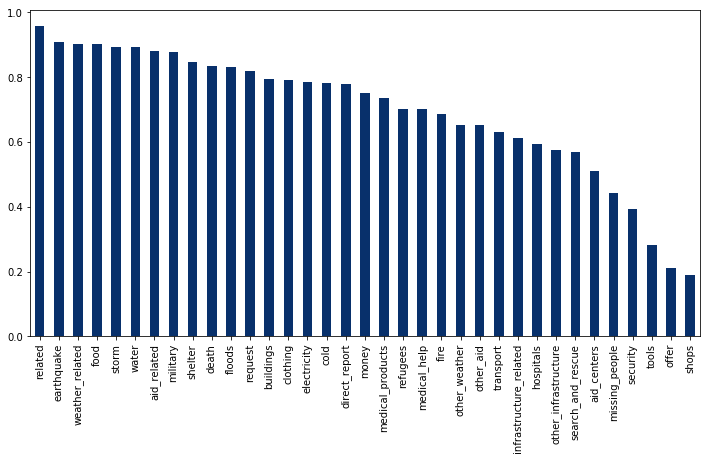

In [274]:
# scores of train data
y_train_pred = cv.predict(x_train)
plot_scores(y_train, y_train_pred)

related
              precision    recall  f1-score   support

           0       0.65      0.54      0.59      1610
           1       0.86      0.91      0.88      4944

   micro avg       0.82      0.82      0.82      6554
   macro avg       0.76      0.72      0.74      6554
weighted avg       0.81      0.82      0.81      6554

request
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      5443
           1       0.77      0.57      0.66      1111

   micro avg       0.90      0.90      0.90      6554
   macro avg       0.84      0.77      0.80      6554
weighted avg       0.89      0.90      0.89      6554

offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6521
           1       0.00      0.00      0.00        33

   micro avg       0.99      0.99      0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.99      0.99      0.99      655

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      6257
           1       0.80      0.42      0.56       297

   micro avg       0.97      0.97      0.97      6554
   macro avg       0.89      0.71      0.77      6554
weighted avg       0.97      0.97      0.96      6554

other_aid
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      5690
           1       0.45      0.20      0.28       864

   micro avg       0.86      0.86      0.86      6554
   macro avg       0.67      0.58      0.60      6554
weighted avg       0.83      0.86      0.84      6554

infrastructure_related
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      6143
           1       0.30      0.10      0.15       411

   micro avg       0.93      0.93      0.93      6554
   macro avg       0.62      0.54      0.56      6554
weighted avg       0.90      0.93      0.

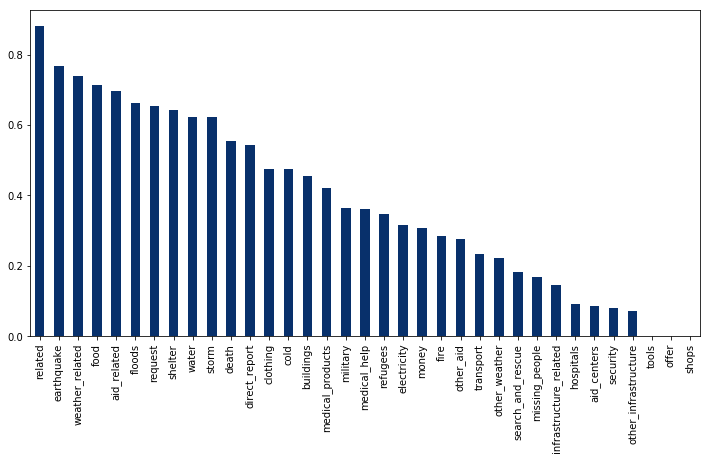

In [273]:
# scores of test data
y_test_pred = cv.predict(x_test)
plot_scores(y_test, y_test_pred)

## Classification by vec2 words (Gave Up!!!!!!!)

In [221]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

from keras.preprocessing import text, sequence

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(x_train)
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(x_train), maxlen=70)
test_seq_x = sequence.pad_sequences(token.texts_to_sequences(x_test), maxlen=70)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

#  4.Export your model as a pickle file

In [301]:
with open("classifier.pkl", 'wb') as file:
    pickle.dump(cv, file)

# 5. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.